# Training Notebook

This notebook contains the code for training the model on the MNIST dataset, evaluation can be found at [test.ipynb](https://github.com/ammar-elsabe/handwritten-digit-recognition-DCNN/blob/master/src/test.ipynb)

## Imports

For training the model, we need only tensorflow and tensorflow_datasets, which will be used to retrieve the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Loading the dataset
We use the [load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method to load the mnist dataset

In [2]:
# Import the dataset mnist is 60k images of 28x28 pixels
# And 10k images for testing
(dstrain, dstest), dsinfo = tfds.load(
    'mnist',
    split=['train', 'test'],
    data_dir='../dataset/',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-04-24 22:37:35.285969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:37:35.313828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:37:35.313985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:37:35.314449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Print the image shape and class names

In [3]:
# Summarize loaded datasets
print('\nDataset info:')
print('Image shape:')
print(dsinfo.features['image'].shape)
print('Class Names')
print(dsinfo.features['label'].names)


Dataset info:
Image shape:
(28, 28, 1)
Class Names
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Visualize an image from the dataset

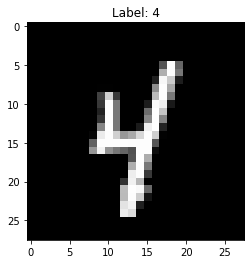

2022-04-24 22:37:42.374927: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
# Visualize a single image
def visualize_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title('Label: {}'.format(label))
    plt.show()


# Now use that function
mnist_example = dstrain.take(1)
for sample in mnist_example:
    image, label = sample[0], sample[1]
    visualize_image(image, label)
    break

## Preprocessing
We preprocess the data by batching it, and applying an autotuned prefetch to make the fetching of the data faster

Note: instead of preprocessing the data right now, we have a resizing layer in the model architecture

From the Tensorflow Documentation:
> Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [5]:
batch_size = 128

dstrain = dstrain.batch(batch_size)
dstrain = dstrain.cache()
dstrain = dstrain.shuffle(dsinfo.splits['train'].num_examples)
dstrain = dstrain.prefetch(tf.data.AUTOTUNE)

We do the same for the testing set

In [6]:
dstest = dstest.batch(batch_size)
dstest = dstest.cache()
dstest = dstest.prefetch(tf.data.AUTOTUNE)

## The Model

We then create the model architecture

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

We compile the model, where we use the adam optimizer, which is a version of stochastic gradient descent, and cross categorical cross entropy for the loss function which is mathematically written as:
$$
J(\textbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \text{log}(\hat{y}_i) + (1-y_i) \text{log}(1-\hat{y}_i) \right]
$$
We then build the model, and print the summary

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# build the model
model.build()
# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 28)       112       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 28)        7084      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 28)         0

Create the architecture diagram and save it to an svg

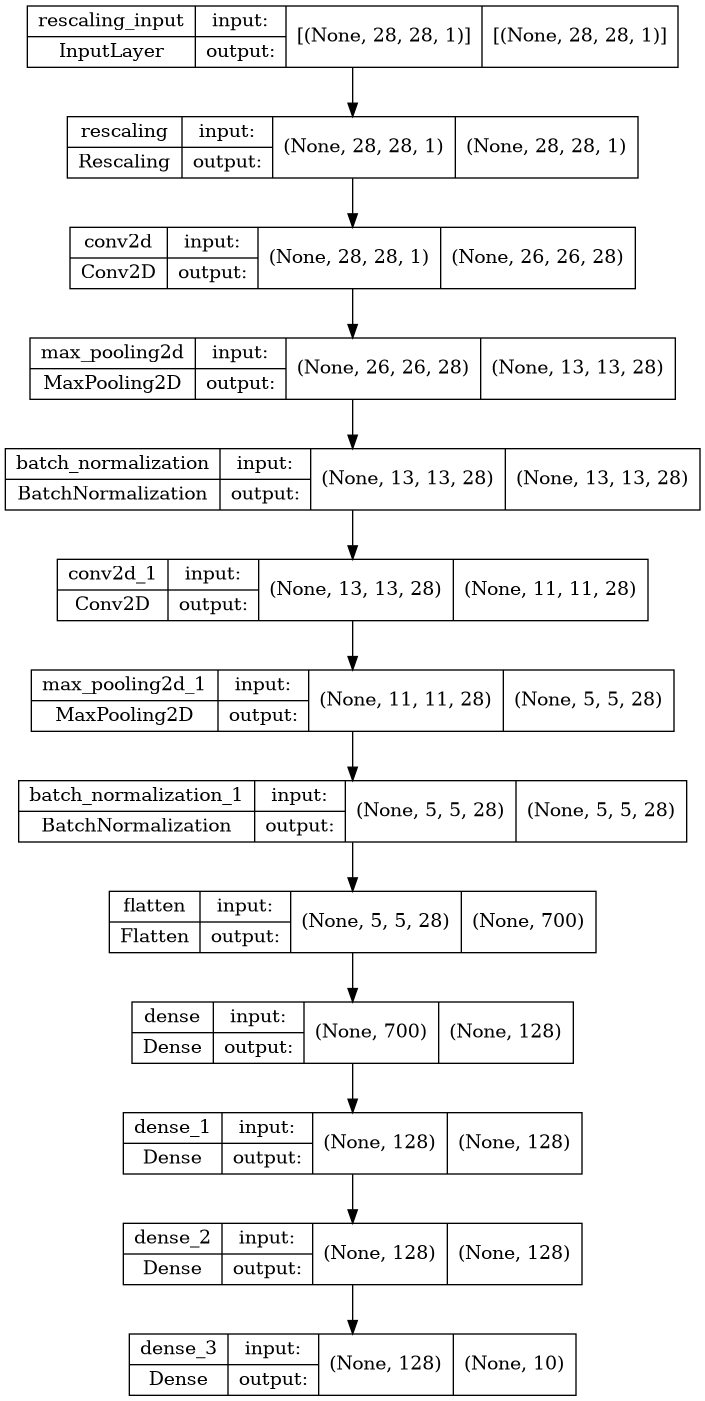

In [9]:
import pydot
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)


architecture = tf.keras.utils.model_to_dot(model, show_shapes = True)
view_pydot(architecture)
architecture.write_svg('../paper/figs/cnn_architecture.svg')

We them train the model, with an early stopping callback, and saving the best model along the way

In [10]:
history = model.fit(
    dstrain,
    epochs=30,
    validation_data=dstest,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1)
    ]
)

Epoch 1/30


2022-04-24 22:38:03.283133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


461/469 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9598
Epoch 1: val_loss improved from inf to 0.21989, saving model to model.h5
469/469 [==============================] - 8s 5ms/step - loss: 0.1315 - accuracy: 0.9603 - val_loss: 0.2199 - val_accuracy: 0.9304
Epoch 2/30
465/469 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9878
Epoch 2: val_loss improved from 0.21989 to 0.03657, saving model to model.h5
469/469 [==============================] - 2s 5ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0366 - val_accuracy: 0.9877
Epoch 3/30
469/469 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9918
Epoch 3: val_loss improved from 0.03657 to 0.03342, saving model to model.h5
469/469 [==============================] - 2s 5ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0334 - val_accuracy: 0.9891
Epoch 4/30
466/469 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9939
Epoch 4

Plot the accuracies and the losses across the range of epochs

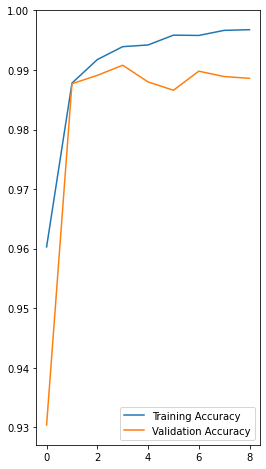

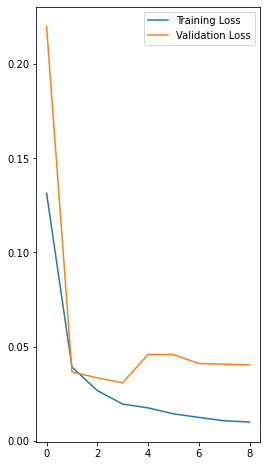

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(4, 8))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig('../paper/figs/accuracy.svg', format='svg')
plt.show()

plt.figure(figsize=(4, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.savefig('../paper/figs/loss.svg', format='svg')
plt.show()